In [25]:
import pandas as pd


def load_data():
    # 注意配置工作目录 >> jupyter.notebookFileRoot
    data = pd.read_csv("data/house_price_shanghai/dataset.csv")
    return data


pd.set_option("display.max_columns", None)
house_data = load_data()
house_data.head()

,标题,居室数,厅堂数,卫生间数,总面积,建造年份,居民楼总层数,小区户数,小区绿化率,物业费用,小区均价,装修,楼层分布,物业类型,产权性质,产权年限,房本年限,区,街道,小区,南,南北,近地铁,车位充足,户型方正,多人关注,有电梯,价格
0,扫码唻电联系房东，真的急疯了，这价格还卖不掉房东说要刀了我！,2,1,1,17,2018.0,11.0,50.0,30.0,0.40,28445.0,精装修,中层,普通住宅,商品房住宅,70年产权,满五年,闵行,虹桥,虹中路2弄小区,False,True,True,True,False,False,False,50
1,正南 3室2厅 万科海上传奇(一二期),3,2,1,97,2014.0,22.0,2336.0,45.0,3.00,103551.0,简单装修,低层,普通住宅,商品房住宅,70年产权,满二年,浦东,御桥,万科海上传奇(一二期),True,False,True,False,False,False,False,910
2,虹浦新城南区 通透三房 预约看房,3,1,1,93,2007.0,11.0,1731.0,30.0,1.25,34202.0,毛坯,高层,普通住宅,商品房住宅,未知,未知,闵行,浦江,虹浦新城(南区),False,True,True,False,False,False,True,355
3,18号地铁口！进才 ，南北通透沉香苑，房东置换急 售,2,2,1,90,2013.0,11.0,971.0,35.0,1.20,35224.0,精装修,中层,普通住宅,商品房住宅,70年产权,满五年,浦东,航头,沉香苑一街坊,False,True,True,False,True,False,False,286
4,市区独栋别墅！送400平大花园！自带私家游泳池！位置不靠马路,5,3,3,300,2010.0,2.0,68.0,43.0,5.50,188277.0,精装修,全层,别墅,商品房住宅,70年产权,满五年,闵行,虹桥,虹梅别墅,True,False,True,True,False,False,False,4100


### 数据预处理

In [21]:
def process_data(data, stage: list[int]):
    """
    数据处理流程
    """
    if 1 in stage:
        data["建筑年龄"] = 2023 - house_data["建造年份"]
        data = data.drop("建造年份", axis=1)

    if 2 in stage:
        data["单价"] = data["价格"] / data["总面积"]
        district_avg_price = data.groupby("小区")["单价"].transform("mean")
        data["小区平均单价"] = district_avg_price

        district_avg_price = data.groupby("街道")["单价"].transform("mean")
        data["街道平均单价"] = district_avg_price

        # district_avg_price = data.groupby("区")["单价"].transform("mean")
        # data["区平均单价"] = district_avg_price
        data = data.drop("单价", axis=1)

    if 3 in stage:
        binary_features = ['南', '南北', '近地铁', '车位充足', '户型方正', '多人关注', '有电梯']
        for feature in binary_features:
            data[feature] = data[feature].map({True: 1, False: 0})

        # 独热编码
        data = pd.get_dummies(data, columns=['楼层分布', '房本年限'], drop_first=True)

    return data

### 基础模型

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline


def train_line_model(data):
    X = (
        data.select_dtypes(include=["float", "int"])
        .drop("价格", axis=1)
        .drop("小区均价", axis=1)
    )
    y = data["价格"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)

    y_pred = lin_reg.predict(X_test)
    return y_pred, y_test


def train_poly_model(data):
    # 创建线性回归模型
    X = (
        data.select_dtypes(include=["float64", "int64"])
        .drop("价格", axis=1)
        .drop("小区均价", axis=1)
    )
    y = data["价格"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    poly_model = Pipeline(
        [
            ("poly", PolynomialFeatures(degree=2)),  # 创建多项式特征
            ("linear", LinearRegression()),  # 使用线性回归拟合变换后的特征
        ]
    )
    poly_model.fit(X_train, y_train)

    y_pred = poly_model.predict(X_test)
    return y_pred, y_test

### 评估指标

In [5]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


# 评估模型
def eval_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"均方误差 (MSE): {mse:.2f}")
    print(f"均方根误差 (RMSE): {rmse:.2f}")
    print(f"平均绝对百分比误差 (MAPE): {mape * 100:.2f}%")

### 画图

In [37]:
import matplotlib.pyplot as plt

def plot_scatter(y_test, y_pred):
    # 设置中文字体缺失问题
    plt.rcParams["font.sans-serif"]=["Microsoft YaHei"] #设置字体
    plt.rcParams["axes.unicode_minus"]=False

    # 画个误差图展示
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    # plt.plot([5000, 5000], [5000, 5000], 'k--', lw=2)
    plt.xlabel('实际价格')
    plt.ylabel('预测价格')
    plt.title('实际价格 vs 预测价格')
    plt.tight_layout()
    # plt.savefig('prediction_results.png')
    plt.show()

### 实验一：基础线性回归
使用基本特征，不做特殊处理

#### 观察与分析：
基础模型表现较差，预测误差超过50%，需要改进特征工程。

均方误差 (MSE): 185555.93
均方根误差 (RMSE): 430.76
平均绝对百分比误差 (MAPE): 54.21%


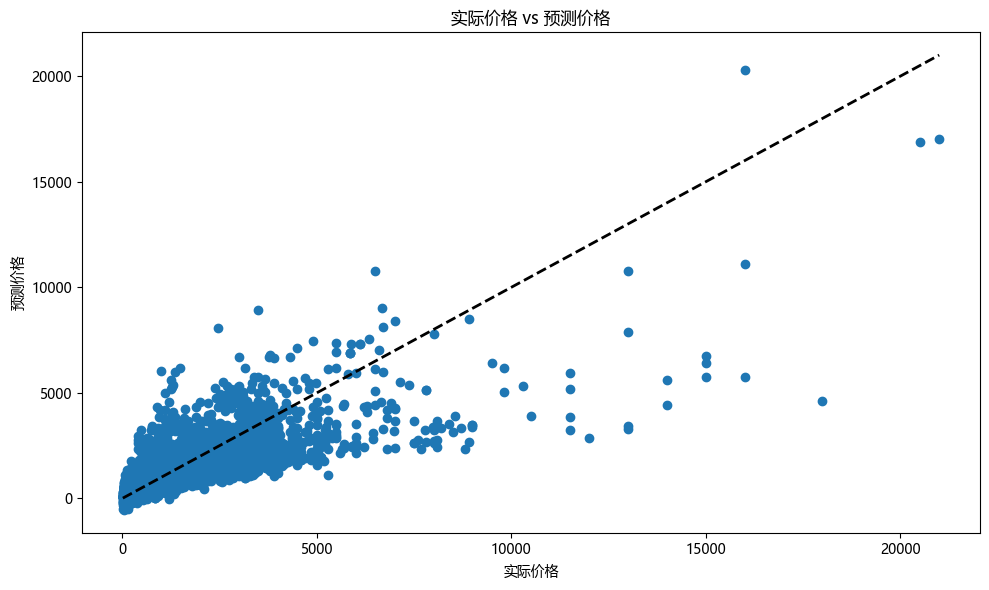

In [39]:
y_pred, y_test = train_line_model(house_data)
eval_model(y_test, y_pred)
plot_scatter(y_test, y_pred)

### 实验二：缺失值处理
检查数据完整性

#### 发现数据质量良好，无缺失值，无需此步骤。

In [29]:
house_data.copy().isnull().sum()

标题        0
居室数       0
厅堂数       0
卫生间数      0
总面积       0
建造年份      0
居民楼总层数    0
小区户数      0
小区绿化率     0
物业费用      0
小区均价      0
装修        0
楼层分布      0
物业类型      0
产权性质      0
产权年限      0
房本年限      0
区         0
街道        0
小区        0
南         0
南北        0
近地铁       0
车位充足      0
户型方正      0
多人关注      0
有电梯       0
价格        0
dtype: int64

### 实验三：时间特征优化
将绝对年份改为相对年龄

均方误差 (MSE): 185555.93
均方根误差 (RMSE): 430.76
平均绝对百分比误差 (MAPE): 54.21%


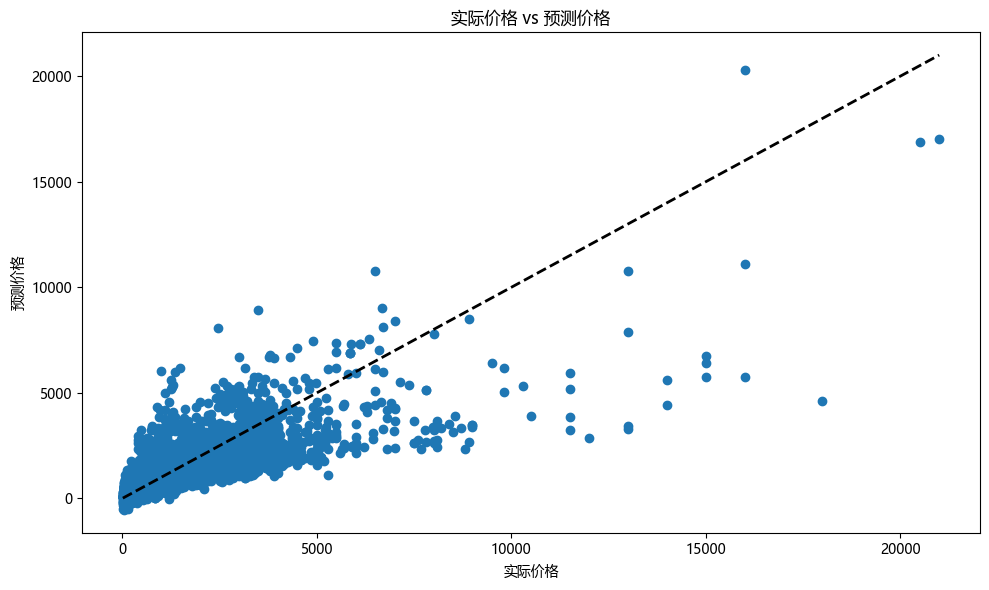

In [40]:
data = process_data(house_data.copy(), [1])
y_pred, y_test = train_line_model(data)
eval_model(y_test, y_pred)
plot_scatter(y_test, y_pred)

#### 观察与分析：
简单替换年份为年龄没有带来性能提升，可能需要进一步探索时间特征的非线性关系。

#### 实验四：引入领域知识
加入小区均价特征

均方误差 (MSE): 90586.96
均方根误差 (RMSE): 300.98
平均绝对百分比误差 (MAPE): 51.38%


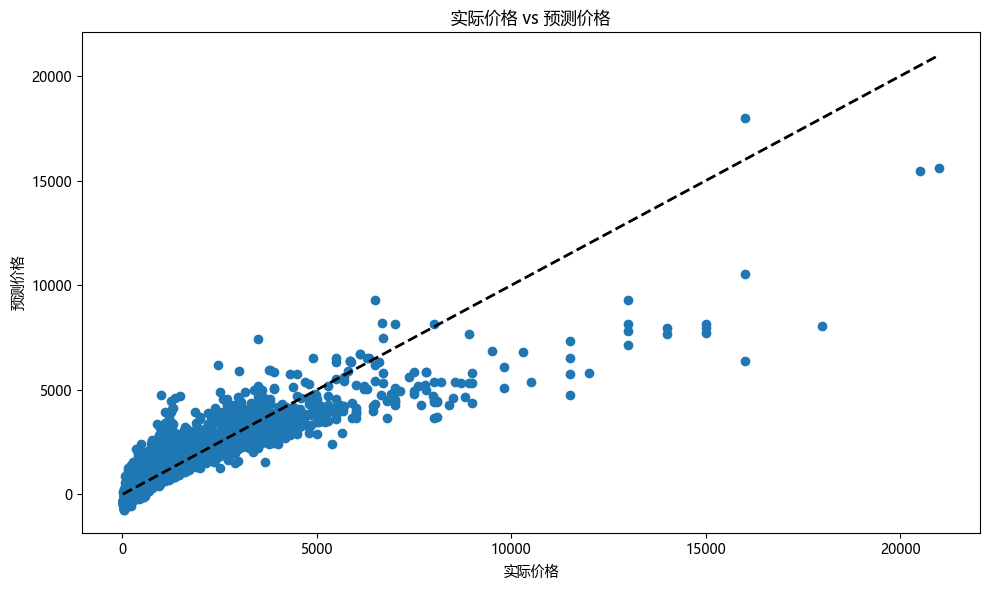

In [41]:
data = process_data(house_data.copy(), [2])
y_pred, y_test = train_line_model(data)
eval_model(y_test, y_pred)
plot_scatter(y_test, y_pred)

### 实验五：特征编码优化
应用二元编码和独热编码

均方误差 (MSE): 175781.93
均方根误差 (RMSE): 419.26
平均绝对百分比误差 (MAPE): 51.39%


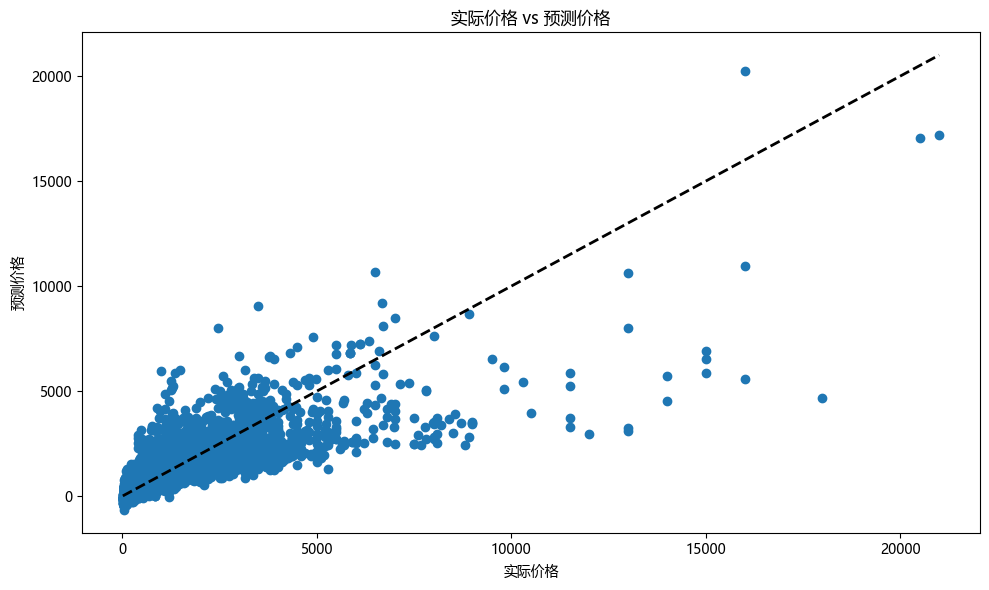

In [42]:
data = process_data(house_data.copy(), [3])
y_pred, y_test = train_line_model(data)
eval_model(y_test, y_pred)
plot_scatter(y_test, y_pred)

###  实验六：多项式回归
引入特征的非线性变换

均方误差 (MSE): 23112.89
均方根误差 (RMSE): 152.03
平均绝对百分比误差 (MAPE): 9.77%


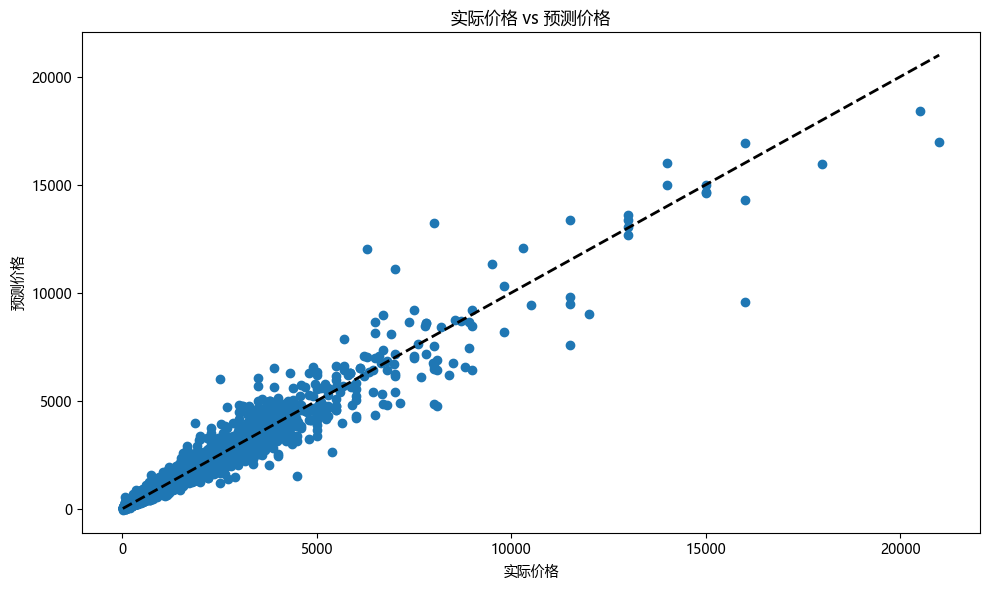

In [43]:
data = process_data(house_data.copy(), [2])
y_pred, y_test = train_poly_model(data)
eval_model(y_test, y_pred)
plot_scatter(y_test, y_pred)